In [1]:
import pandas as pd
import seaborn as sns
import cdt
import networkx as nx
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


## EDA Conclusions

#### Session data summary:

count    10000.000000 \
mean        16.788000  \
std          3.808321 \
min         10.000000 \
25%         13.000000 \
50%         20.000000 \
75%         20.000000 \
max         20.000000 

#### Songs data
Unique songs = 167880
Skipped songs = 33.29%

### Skip Analysis
Relation between the skips \
if skip_1 == True then skip_2 = True \
if skip_2 == True then skip_3 = True 

<!-- except for track_id_clean = t_32ef9f23-ba4f-4804-b12f-0fd660cc9f19 -->

Of the songs skipped, 50% of the songs were skipped very briefly, 25% skipped briefly, 25% most track played

#### Skip data vs Discrete features
Session position:\
skip_1 = \
skip_2 = \
skip_3 = 

Hour of the day:\
skip_1 = sharp decline rapidly after 10\
skip_2 = \
skip_3 = 

In [2]:
# read data
df = pd.read_csv('../../data/training_set/log_mini.csv')

In [3]:
df.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'],
      dtype='object')

In [4]:
# session data summary
df.session_id.value_counts().describe()

count    10000.000000
mean        16.788000
std          3.808321
min         10.000000
25%         13.000000
50%         20.000000
75%         20.000000
max         20.000000
Name: session_id, dtype: float64

In [5]:
# song data
print(f'Total number of songs:', len(df))
skipped_num = df[df['not_skipped'] == True]['not_skipped'].count()
non_skipped_num = df[df['not_skipped'] == False]['not_skipped'].count()
skip_percent = (skipped_num/(non_skipped_num + skipped_num))*100
print('Skipped percent: ', skip_percent)

Total number of songs: 167880
Skipped percent:  33.28806290207291


In [6]:
# skip 1, skip 2, skip 3 relation
df[df['skip_1'] == True]['skip_2'].describe()
df[df['skip_2'] == True]['skip_3'].describe()

count     86824
unique        2
top        True
freq      86823
Name: skip_3, dtype: object

In [7]:
df[df['skip_3'] == True]['skip_2'].describe()

count     108850
unique         2
top         True
freq       86823
Name: skip_2, dtype: object

In [8]:
# skip distributions
# songs that have been skipped

# has skipped songs
# df['is_skip'] = df.apply(lambda x : x.skip_1 or x.skip_2 or x.skip_3, axis=1)
# skipped_df = df[df['is_skip'] == True]
skipped_df = df

# add skip column
def f(s1, s2, s3):
    if s1:
        return 1
    elif s2:
        return 2
    elif s3:
        return 3
    return 0
    
skipped_df['skip'] = skipped_df.apply(lambda x: f(x.skip_1, x.skip_2, x.skip_3), axis=1)
print(skipped_df['skip'].value_counts())
skipped_df['skip'].describe()

1    70762
0    59029
3    22027
2    16062
Name: skip, dtype: int64


count    167880.000000
mean          1.006475
std           0.985942
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: skip, dtype: float64

In [9]:
skipped_df['skip'].value_counts

<bound method IndexOpsMixin.value_counts of 0         0
1         0
2         0
3         0
4         0
         ..
167875    0
167876    0
167877    0
167878    0
167879    0
Name: skip, Length: 167880, dtype: int64>

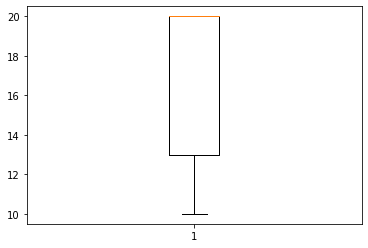

In [187]:
plt.boxplot(skipped_df['session_id'].value_counts())
plt.show()

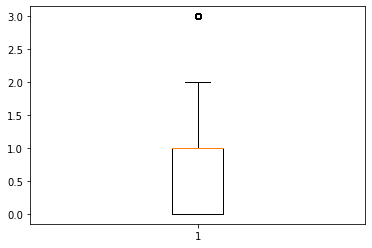

In [188]:
plt.boxplot(skipped_df['skip'])
plt.show()

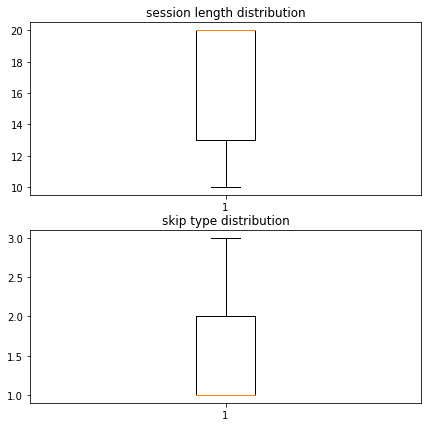

In [189]:
f, axs = plt.subplots(2,figsize=(7,7))
axs[0].boxplot(skipped_df['session_id'].value_counts())
axs[0].set_title('session length distribution')
axs[1].boxplot(skipped_df[skipped_df['skip'] > 0]['skip'])
axs[1].set_title('skip type distribution')
plt.show()

In [190]:
skipped_df['context_type'].value_counts()

user_collection          67430
catalog                  38263
editorial_playlist       35663
radio                    21107
personalized_playlist     2976
charts                    2441
Name: context_type, dtype: int64

In [191]:
skipped_df['context_switch'].value_counts()

0    161013
1      6867
Name: context_switch, dtype: int64

In [27]:
skipped_df['int_shuffle'] = skipped_df['hist_user_behavior_is_shuffle'].astype(int)

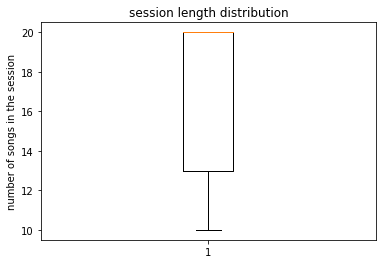

In [11]:
#f, axs = plt.subplots(1,2,figsize=(8,3))
plt.boxplot(skipped_df['session_id'].value_counts())
plt.title('session length distribution')
plt.ylabel('number of songs in the session')

plt.subplots_adjust(wspace=0.3) # hspace=0.5, 
plt.savefig('../../img/session_box.jpg', bbox_inches='tight', dpi=150)
plt.show()
plt.close()

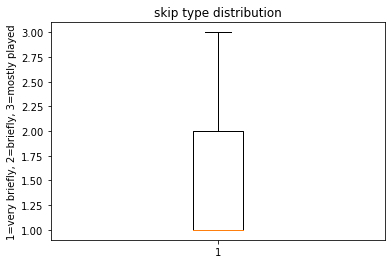

In [13]:
#f, axs = plt.subplots(1,2,figsize=(8,3))

plt.set
plt.boxplot(skipped_df[skipped_df['skip'] > 0]['skip'])
plt.title('skip type distribution')
plt.ylabel('1=very briefly, 2=briefly, 3=mostly played')

plt.subplots_adjust(wspace=0.3) # hspace=0.5, 
plt.savefig('../../img/skip_box.jpg', bbox_inches='tight', dpi=150)
plt.show()
plt.close()

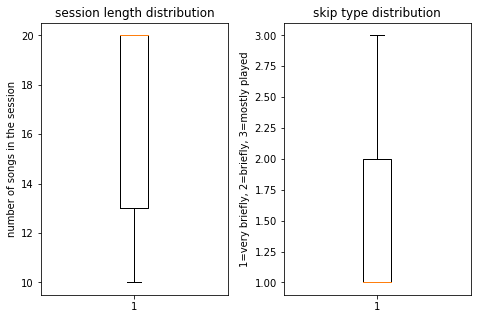

In [24]:
f, axs = plt.subplots(1,2,figsize=(7.7,5))

axs[0].boxplot(skipped_df['session_id'].value_counts())
axs[0].set_title('session length distribution')
axs[0].set_ylabel('number of songs in the session')

axs[1].boxplot(skipped_df[skipped_df['skip'] > 0]['skip'])
axs[1].set_title('skip type distribution')
axs[1].set_ylabel('1=very briefly, 2=briefly, 3=mostly played')

plt.subplots_adjust(wspace=0.3) # hspace=0.5, 
plt.savefig('../../img/session_skip_box-1.jpg', bbox_inches='tight', dpi=150)
plt.show()
plt.close()

In [28]:
skipped_df[skipped_df['skip'] > 0]['context_switch'].value_counts()
skipped_df[skipped_df['skip'] > 0]['int_shuffle'].value_counts()

skipped_df['int_premium'] = skipped_df['premium'].astype(int)
skipped_df[skipped_df['skip'] > 0]['int_premium'].value_counts()

1    88070
0    20781
Name: int_premium, dtype: int64

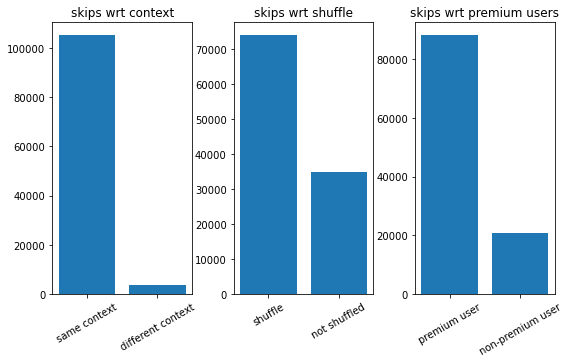

In [48]:
f, axs = plt.subplots(1,3,figsize=(9,5))

label1 = ['same context','different context']

label2 = ['shuffle','not shuffled']

label3 = ['premium user', 'non-premium user']

axs[0].bar(label1, skipped_df[skipped_df['skip'] > 0]['context_switch'].value_counts())
axs[0].set_title('skips wrt context')
axs[0].set_xticklabels(label1, rotation=30)

axs[1].bar(label2, skipped_df[skipped_df['skip'] > 0]['int_shuffle'].value_counts())
axs[1].set_title('skips wrt shuffle')
axs[1].set_xticklabels(label2, rotation=30)

axs[2].bar(label3, skipped_df[skipped_df['skip'] > 0]['int_premium'].value_counts())
axs[2].set_title('skips wrt premium users')
axs[2].set_xticklabels(label3, rotation=30)

plt.subplots_adjust(wspace=0.3) # hspace=0.5, 
plt.savefig('../../img/context_shuffle_premium-1.jpg', bbox_inches='tight', dpi=150)
#plt.xticks(rotation = 45)
plt.show()
plt.close()

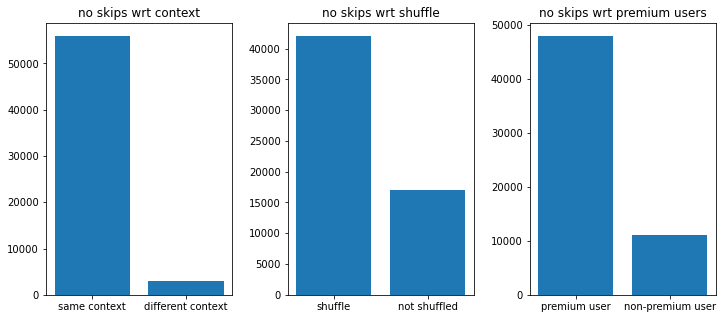

In [196]:
f, axs = plt.subplots(1,3,figsize=(12,5))

label1 = ['same context','different context']

label2 = ['shuffle','not shuffled']

label3 = ['premium user', 'non-premium user']

axs[0].bar(label1, skipped_df[skipped_df['skip'] == 0]['context_switch'].value_counts())
axs[0].set_title('no skips wrt context')

axs[1].bar(label2, skipped_df[skipped_df['skip'] == 0]['int_shuffle'].value_counts())
axs[1].set_title('no skips wrt shuffle')

axs[2].bar(label3, skipped_df[skipped_df['skip'] == 0]['int_premium'].value_counts())
axs[2].set_title('no skips wrt premium users')

plt.subplots_adjust(wspace=0.3) # hspace=0.5, 
plt.savefig('../../img/context_shuffle_premium.jpg', bbox_inches='tight', dpi=150)
plt.show()
plt.close()

In [197]:



# deal context switch separately

# pauses before play vs 

# hour of the day

# context type

In [14]:
def skip_vs_discrete_feat(x_col):
    # y0_data = skipped_df[skipped_df['skip'] == 0][skipped_df['premium'] == premium][x_col].value_counts()
    # y1_data = skipped_df[skipped_df['skip'] == 1][skipped_df['premium'] == premium][x_col].value_counts()
    # y2_data = skipped_df[skipped_df['skip'] == 2][skipped_df['premium'] == premium][x_col].value_counts()
    # y3_data = skipped_df[skipped_df['skip'] == 3][skipped_df['premium'] == premium][x_col].value_counts()
    y0_data = skipped_df[skipped_df['skip'] == 0][x_col].value_counts()
    y1_data = skipped_df[skipped_df['skip'] == 1][x_col].value_counts()
    y2_data = skipped_df[skipped_df['skip'] == 2][x_col].value_counts()
    y3_data = skipped_df[skipped_df['skip'] == 3][x_col].value_counts()
    return y0_data.sort_index(), y1_data.sort_index(), y2_data.sort_index(), y3_data.sort_index()

def plot_discrete_feat(y0_data, y1_data, y2_data, y3_data, x_col, title):
    fig = plt.figure()
    plt.plot(y0_data.index, y0_data.values)
    plt.plot(y1_data.index, y1_data.values)
    plt.plot(y2_data.index, y2_data.values)
    plt.plot(y3_data.index, y3_data.values)
    plt.xlabel(x_col)
    plt.ylabel('skip frequency')
    plt.legend(['not skipped', 'skipped very briefly','skipped briefly','mostly played'])
    plt.title(title)
    return fig

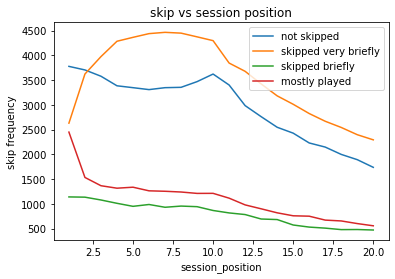

In [17]:
x_col = 'session_position'
y0_data, y1_data, y2_data, y3_data = skip_vs_discrete_feat(x_col=x_col)
p1= plot_discrete_feat(y0_data, y1_data, y2_data, y3_data, x_col, 'skip vs session position')
plt.savefig('../../img/session_pos_skip_freq.jpg', bbox_inches='tight', dpi=150)
plt.show()

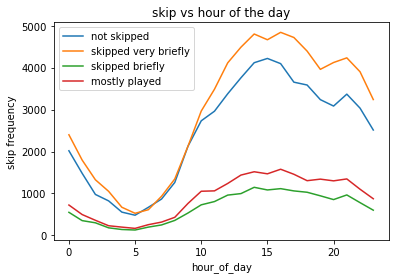

In [18]:
x_col = 'hour_of_day'
y0_data, y1_data, y2_data, y3_data = skip_vs_discrete_feat(x_col=x_col)
p2 = plot_discrete_feat(y0_data, y1_data, y2_data, y3_data, x_col, 'skip vs hour of the day')
plt.savefig('../../img/hour_skip_freq.jpg', bbox_inches='tight', dpi=150)
plt.show()

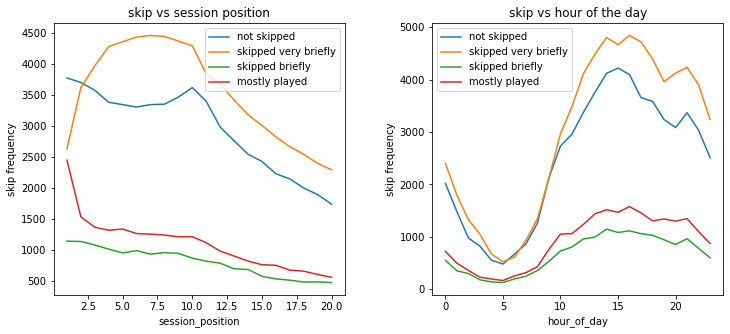

In [226]:
f, axs = plt.subplots(1,2,figsize=(12,5))

x_col = 'session_position'
y0_data, y1_data, y2_data, y3_data = skip_vs_discrete_feat(x_col=x_col)

axs[0].plot(y0_data.index, y0_data.values)
axs[0].plot(y1_data.index, y1_data.values)
axs[0].plot(y2_data.index, y2_data.values)
axs[0].plot(y3_data.index, y3_data.values)
axs[0].set_xlabel(x_col)
axs[0].set_ylabel('skip frequency')
axs[0].legend(['not skipped', 'skipped very briefly','skipped briefly','mostly played'])
axs[0].set_title('skip vs session position')

x_col = 'hour_of_day'
y0_data, y1_data, y2_data, y3_data = skip_vs_discrete_feat(x_col=x_col)

axs[1].plot(y0_data.index, y0_data.values)
axs[1].plot(y1_data.index, y1_data.values)
axs[1].plot(y2_data.index, y2_data.values)
axs[1].plot(y3_data.index, y3_data.values)
axs[1].set_xlabel(x_col)
axs[1].set_ylabel('skip frequency')
axs[1].legend(['not skipped', 'skipped very briefly','skipped briefly','mostly played'])
axs[1].set_title('skip vs hour of the day')

plt.subplots_adjust(wspace=0.3) # hspace=0.5, 
plt.savefig('../../img/skip_freq.jpg', bbox_inches='tight', dpi=150)

Convert skip to a binary variable

In [202]:
skipped_df['custom_skip'] = skipped_df.apply(lambda x: 1 if x.skip > 0 else 0, axis=1)
skipped_df['custom_skip'].value_counts()

1    108851
0     59029
Name: custom_skip, dtype: int64

In [203]:
def skip_vs_discrete_feat1(x_col, premium=1):
    y0_data = skipped_df[skipped_df['custom_skip'] == 0][skipped_df['premium'] == premium][x_col].value_counts()
    y1_data = skipped_df[skipped_df['custom_skip'] == 1][skipped_df['premium'] == premium][x_col].value_counts()
    return y0_data.sort_index(), y1_data.sort_index()

def plot_discrete_feat1(y0_data, y1_data, x_col, title):
    fig = plt.figure()
    plt.plot(y0_data.index, y0_data.values)
    plt.plot(y1_data.index, y1_data.values)
    plt.xlabel(x_col)
    plt.ylabel('frequency')
    plt.legend(['not skipped', 'skipped'])
    plt.title(title)
    return fig

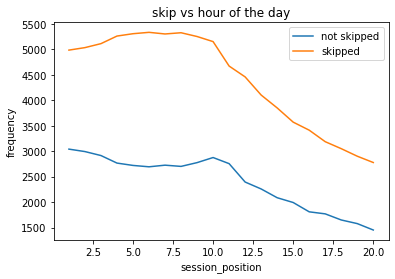

In [212]:
x_col = 'session_position'
y1_data, y2_data = skip_vs_discrete_feat1(x_col=x_col)
p = plot_discrete_feat1(y1_data, y2_data, x_col, 'skip vs hour of the day')
plt.show()

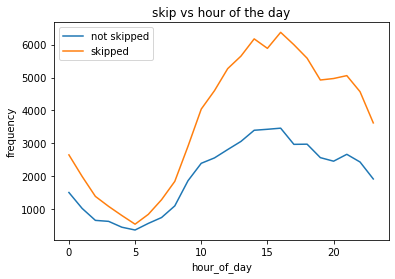

In [204]:
x_col = 'hour_of_day'
y1_data, y2_data = skip_vs_discrete_feat1(x_col=x_col)
p = plot_discrete_feat1(y1_data, y2_data, x_col, 'skip vs hour of the day')
plt.show()

In [205]:
skipped_df.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'skip', 'int_shuffle', 'int_premium', 'custom_skip'],
      dtype='object')

In [206]:
pause_cols = ['no_pause_before_play', 'short_pause_before_play', 'long_pause_before_play']
for col in pause_cols:
    print(col)
    print(skipped_df[col].value_counts())

no_pause_before_play
1    128865
0     39015
Name: no_pause_before_play, dtype: int64
short_pause_before_play
0    143263
1     24617
Name: short_pause_before_play, dtype: int64
long_pause_before_play
0    138865
1     29015
Name: long_pause_before_play, dtype: int64


In [207]:
# every short pause is a long pause
df[df['short_pause_before_play'] == 1]['long_pause_before_play'].value_counts()
#df[df['long_pause_before_play'] == 1]['short_pause_before_play'].value_counts()

1    24617
Name: long_pause_before_play, dtype: int64

In [208]:
df[df['short_pause_before_play'] == 1]['long_pause_before_play'].value_counts()
# add pause before play
def f(s1, s2):
    if s1:
        return 1
    elif s2:
        return 2
    return 0
    
skipped_df['pause_before_play'] = skipped_df.apply(lambda x: f(x.short_pause_before_play, x.long_pause_before_play), axis=1)
print(skipped_df['pause_before_play'].value_counts())
skipped_df['pause_before_play'].describe()

0    138865
1     24617
2      4398
Name: pause_before_play, dtype: int64


count    167880.000000
mean          0.199029
std           0.460231
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: pause_before_play, dtype: float64

In [209]:
skipped_df['custom_pause_before_play'] = skipped_df.apply(lambda x: 1 if x.pause_before_play > 0 else 0, axis=1)

In [210]:
skipped_df['custom_pause_before_play'].value_counts()

0    138865
1     29015
Name: custom_pause_before_play, dtype: int64

In [211]:
skipped_df.to_csv('../../data/session-df-ak.csv')